# 3D Menger Sponge

Build a 3D Menger sponge (20-cube variant) of recursion depth `level`.

Returns a 3D NumPy boolean array (True = solid, False = removed).

The rule: remove subcubes where >=2 coordinates == 1.

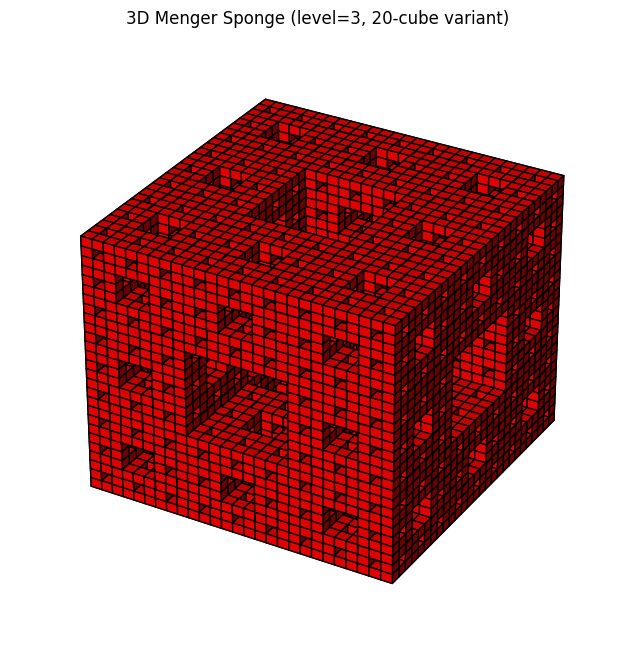

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def menger_sponge_3d(level):
    """
    Build a 3D Menger sponge (20-cube variant) of recursion depth `level`.
    Returns a 3D NumPy boolean array (True = solid, False = removed).
    
    The rule: remove subcubes where >=2 coordinates == 1.
    """
    if level == 0:
        # Base case: a single voxel
        return np.ones((1, 1, 1), dtype=bool)
    
    prev = menger_sponge_3d(level - 1)
    n = prev.shape[0]
    new_n = n * 3
    
    sponge = np.zeros((new_n, new_n, new_n), dtype=bool)
    
    for i in range(3):
        for j in range(3):
            for k in range(3):
                # Count how many coordinates equal 1
                count_ones = (i == 1) + (j == 1) + (k == 1)
                # Skip subcubes if 2 or 3 of the coords are 1
                if count_ones >= 2:
                    continue
                sponge[i*n:(i+1)*n,
                       j*n:(j+1)*n,
                       k*n:(k+1)*n] = prev
    return sponge

# Example usage & visualization
if __name__ == "__main__":
    level = 3  # You can try 2, 3, or 4… but be careful with memory for large levels
    sponge_3d = menger_sponge_3d(level)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(sponge_3d, facecolors='red', edgecolor='k')
    ax.set_title(f"3D Menger Sponge (level={level}, 20-cube variant)")
    ax.axis('off')
    plt.show()


# 4D Menger Hyper-Sponge

Build a 4D Menger sponge via recursive integer subdivision.

At each level, the hypercube is subdivided into 3^4 sub-hypercubes.

For 4D, we remove those sub-hypercubes in which three or more of the indices equal 1.

(i.e. we keep a sub-hypercube if the count of ones in (i,j,k,l) is <= 2.)

Generating slice for w = 0.0
Generating slice for w = 0.1111111111111111
Generating slice for w = 0.2222222222222222
Generating slice for w = 0.3333333333333333
Generating slice for w = 0.4444444444444444
Generating slice for w = 0.5555555555555556
Generating slice for w = 0.6666666666666666
Generating slice for w = 0.7777777777777777
Generating slice for w = 0.8888888888888888
Generating slice for w = 1.0


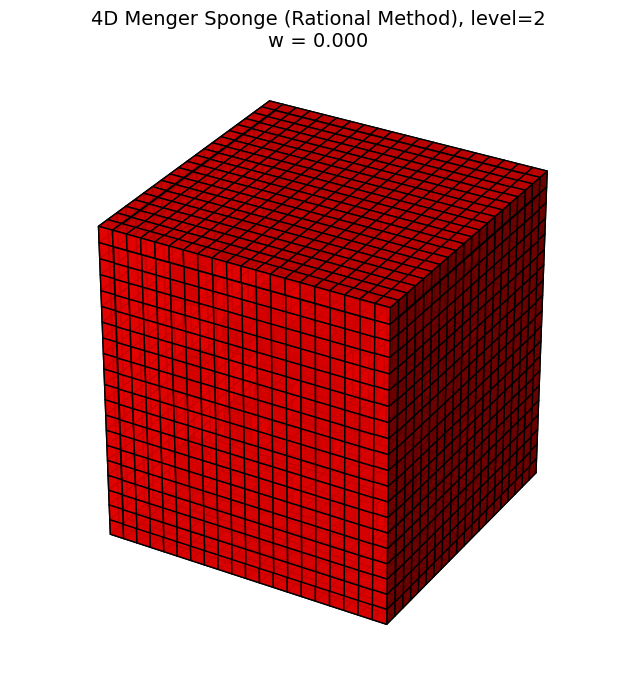

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from fractions import Fraction

# -------------------------------
# Integer Method: Recursive Construction
# -------------------------------
def hyper_menger_sponge_4d_integer(level):
    """
    Build a 4D Menger sponge via recursive integer subdivision.
    At each level, the hypercube is subdivided into 3^4 sub-hypercubes.
    For 4D, we remove those sub-hypercubes in which three or more of the indices equal 1.
    (i.e. we keep a sub-hypercube if the count of ones in (i,j,k,l) is <= 2.)
    """
    if level == 0:
        return np.ones((1, 1, 1, 1), dtype=bool)
    
    prev = hyper_menger_sponge_4d_integer(level - 1)
    n = prev.shape[0]
    new_n = n * 3
    sponge = np.zeros((new_n, new_n, new_n, new_n), dtype=bool)
    
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    # Count how many coordinates equal 1.
                    # In the 4D construction, we remove the sub-hypercube if three or more coordinates equal 1.
                    if (i == 1) + (j == 1) + (k == 1) + (l == 1) >= 3:
                        continue
                    sponge[i*n:(i+1)*n,
                           j*n:(j+1)*n,
                           k*n:(k+1)*n,
                           l*n:(l+1)*n] = prev
    return sponge

# -------------------------------
# Rational Method: Membership Test with Exact Fractions
# -------------------------------
def in_hyper_menger_4d_rational(x, y, z, w, level):
    """
    Check membership for the 4D Menger sponge using exact rational arithmetic.
    Here x, y, z, and w are Fraction objects.
    
    For 4D, the rule is that at each ternary digit (up to 'level' digits),
    if three or more of the digits (from x, y, z, w) equal 1, the point is removed.
    Otherwise, if this never happens, the point is in the sponge.
    """
    for _ in range(level):
        x *= 3
        y *= 3
        z *= 3
        w *= 3
        
        ix = int(x)  # floor, exactly
        iy = int(y)
        iz = int(z)
        iw = int(w)
        
        if (ix == 1) + (iy == 1) + (iz == 1) + (iw == 1) >= 3:
            return False
        
        x -= ix
        y -= iy
        z -= iz
        w -= iw
    return True

def generate_3d_slice_rational(w_val, N, level):
    """
    Generate a 3D slice (an N×N×N boolean array) of the 4D Menger sponge
    at the 4th coordinate w = w_val using exact rational arithmetic.
    
    The parameter 'level' determines the number of ternary digits checked.
    """
    # Convert w_val (a float in [0,1]) to a Fraction.
    w = Fraction(w_val).limit_denominator(3**level)
    data = np.zeros((N, N, N), dtype=bool)
    for i in range(N):
        x = Fraction(i, N - 1)
        for j in range(N):
            y = Fraction(j, N - 1)
            for k in range(N):
                z = Fraction(k, N - 1)
                if in_hyper_menger_4d_rational(x, y, z, w, level):
                    data[i, j, k] = True
    return data

# -------------------------------
# Animation Function
# -------------------------------
def animate_sponge(level=2, method='integer', N=None, frames=10):
    """
    Animate 3D slices of the 4D Menger sponge.
    
    Parameters:
      - level: iteration level (depth) of the sponge.
      - method: 'integer' or 'rational'
          * 'integer': Build the full 4D sponge exactly via recursion.
          * 'rational': Compute each 3D slice on the fly using exact rational arithmetic.
      - N: Resolution for the rational method (number of sample points per axis).
           (Ignored for the integer method, whose resolution is 3^level.)
      - frames: Number of slices to animate along the 4th dimension.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect((1, 1, 1))
    ax.axis('off')
    
    slices = []
    
    if method == 'integer':
        # Build the full 4D sponge tensor.
        sponge = hyper_menger_sponge_4d_integer(level)
        res = sponge.shape[0]  # Resolution = 3^level
        # For the integer method, we can only take slices at integer indices.
        w_indices = np.linspace(0, res - 1, frames, dtype=int)
        for w in w_indices:
            slices.append(sponge[:, :, :, w])
        title_prefix = f"4D Menger Sponge (Integer Method), level={level}"
    elif method == 'rational':
        if N is None:
            N = 20  # default resolution for rational method
        # For the rational method, we choose w in [0,1] continuously.
        w_values = np.linspace(0, 1, frames)
        for w in w_values:
            print("Generating slice for w =", w)
            slices.append(generate_3d_slice_rational(w, N, level))
        title_prefix = f"4D Menger Sponge (Rational Method), level={level}"
    else:
        raise ValueError("Method must be either 'integer' or 'rational'.")
    
    def update(frame):
        ax.cla()
        ax.set_box_aspect((1, 1, 1))
        ax.axis('off')
        if method == 'integer':
            title = f"{title_prefix}\nSlice index = {w_indices[frame]}"
        else:
            title = f"{title_prefix}\nw = {w_values[frame]:.3f}"
        ax.set_title(title, fontsize=14)
        ax.voxels(slices[frame], facecolors='red', edgecolor='k', alpha=0.9)
        return ax,
    
    ani = FuncAnimation(fig, update, frames=len(slices), interval=500, blit=False)
    return ani

# -------------------------------
# Example Application
# -------------------------------
if __name__ == "__main__":
    # You can change these parameters as desired:
    chosen_level = 2      # The fractal iteration level (e.g., 0, 1, 2, ...)
    chosen_method = 'rational'  # 'integer' or 'rational'
    resolution = 20       # For the rational method only; ignored for integer method.
    num_frames = 10       # Number of slices along the 4th dimension.
    
    ani = animate_sponge(level=chosen_level, method=chosen_method,
                         N=resolution, frames=num_frames)
    
    # In a Jupyter Notebook, use the following to display the animation:
    HTML(ani.to_jshtml())
    ani.save('menger_4d.mp4', fps=2) # To save to a file
    # Otherwise, in a regular Python script, use:
    # plt.show()